In [21]:
import math
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV  
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pylab as plt
from util import *
%matplotlib inline

In [22]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
ind = np.arange(2,36)

In [23]:
deg = 2
train['y'] = train['y'].apply(lambda x: x**(1.0/deg))

In [24]:
def calc_date(x):
    x[1] = x[1] - x[2] + 1;
    if (x[1] > 0):
        return x
    
    x[0] -= 1
    x[1] += 52
    return x

In [25]:
def get_first_nonzero(x):
    answer = 30
    i = 3
    while (i < 33) :
        if (x[i] > 0) :
            break
        
        answer-=1
        i+=1
    return answer

In [26]:
X = train.copy().take(ind, axis=1)
X[['year', 'week', 'shift']] = X[['year', 'week', 'shift']].apply(lambda x : calc_date(x), axis=1)
X = X[np.invert(X.duplicated(['item_id', 'year', 'week']))]
X = X.drop('shift', axis=1)

y = train.get(['y', 'week', 'year', 'item_id'])
y = y[np.invert(y.duplicated(['item_id', 'year', 'week']))]

In [27]:
df = pd.merge(X, y, on=['item_id', 'year', 'week'])
df['nonzero']=df.apply(lambda x : get_first_nonzero(x), axis=1)
df = df[df.nonzero!=0]

In [28]:
X_train = df.drop(['y'], axis=1)
y_train = df['y']

In [29]:
model = GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=43)
model.fit(X_train, y_train)
X_pred = model.predict(X_train)
err = abs(X_pred**deg - y_train**deg)

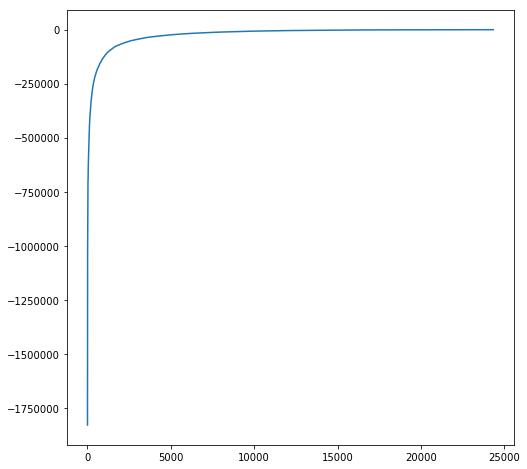

-23849.4128425


In [30]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(err.size), np.array(sorted(-err)))
plt.show()
print sorted(-err)[5000]

In [31]:
model.feature_importances_

array([ 0.01704724,  0.16160672,  0.00220348,  0.00569741,  0.00639448,
        0.00371559,  0.00909129,  0.07679614,  0.00131585,  0.0031036 ,
        0.00738331,  0.06685461,  0.00042189,  0.00018836,  0.00214188,
        0.00079476,  0.00051744,  0.        ,  0.00235865,  0.00083734,
        0.01372451,  0.00163681,  0.00075792,  0.01382511,  0.06921972,
        0.01151359,  0.00198102,  0.00197116,  0.07122916,  0.13102509,
        0.10702882,  0.12131732,  0.08290459,  0.00339512])

In [32]:
mask = abs(X_pred**deg - y_train**deg) < 100000
X_train= X_train[mask]
y_train = y_train[mask]
print y_train.size

23053


In [23]:
model_final =XGBRegressor(
           min_child_weight=15,
           n_estimators=1200,
           max_depth=9,
           learning_rate =0.01,
           subsample=0.85,
           gamma=0.1,
           colsample_bytree=1,
           seed=4, 
           nthread=-1)
model_final.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=15, missing=None, n_estimators=1200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=4, silent=True, subsample=0.85)

In [24]:
test = pd.read_csv("test.tsv")
test.rename(columns ={'shift':'shif'}, inplace=True)
one_week = test[test.shif==1].drop(['shif'], axis=1)
X_test = one_week.drop(['Num'], axis=1).take(np.arange(0,33), axis=1)
X_test['nonzero']=X_test.apply(lambda x : get_first_nonzero(x), axis=1)

In [25]:
y_test = model_final.predict(X_test)
y_test = pd.Series(y_test**2, name='y')

answer=X_test[['year', 'week', 'item_id']]
answer.index=np.arange(672)
answer = pd.concat([answer, y_test], axis=1)

In [26]:
filler = test[['Num', 'year', 'week', 'item_id']]

In [27]:
an = pd.merge(filler, answer, on=['item_id', 'year', 'week'], how='left')
an = an[['Num', 'y']]

In [28]:
an

,Num,y
0,348622,1979.381592
1,348623,23601.996094
2,348624,326103.187500
3,348625,34977.285156
4,348626,87.534431
5,348627,144493.250000
6,348628,88337.679688
7,348629,81999.453125
8,348630,87477.734375
9,348631,2783.182617


In [29]:
leak = pd.read_csv("leak.tsv")

In [30]:
full = pd.merge(an, leak, on=['Num'], how='left')
full['y'] = full[['y', 'l']].apply(lambda x: x[0] if math.isnan(x[1]) else x[1], axis=1)

In [31]:
full

,Num,y,l
0,348622,1497.000000,1497.0
1,348623,27033.000000,27033.0
2,348624,297560.000000,297560.0
3,348625,29471.000000,29471.0
4,348626,16.000000,16.0
5,348627,146242.000000,146242.0
6,348628,67735.000000,67735.0
7,348629,111941.000000,111941.0
8,348630,102631.000000,102631.0
9,348631,3542.000000,3542.0


In [73]:
full[['Num', 'y']].to_csv("XGB_l.tsv", sep=',', index=False)